# Many-to-Many Document Similarity Task

In this section, we implement the traditional LSH appraoch to a hypothetical many-to-many document similarity task. The objective is to bucket similar documents together. The implementation is done through the `LSH` class which leverages on `dask.bag` functionality and methods to *parallelize* the **banding technique**. Specifically, the map (hash function) and reduce (bucketing) tasks.

The `LSH` has three main methods:

* `make_bands` - This method takes in the desired number of `bands` as a parameter and returns a dictionary with band labels as keys and `dask.bag` of (set/document index, signature band) tuples. Here, signature bands are defined as a slice of a document's signature.
    * Parameters
        - `bands` - (int) desired number of bands
    * Returns
        - `band_dict` - (dict) dictionary with band labels as keys and (set/doc index, signature band) tuples as values
        
* `get_buckets` - This method implementes the map-reduce step of the traditional banding technique. Specifically, signature slices of each band are hashed using `hash_functions` (map). The document indices are then grouped according to their hash values.

    * Parameters
        - `hash_functions` - (list, default=None) a list of hash functions with size equivalent to the number of bands. A hash function in the list is applied to a band with the same index. When None, the funciton defaults to using the python builtin `hash` function. *Note: python's hash function value for the same input vary across partitions--hence, current implementation stores all elements of a band in one partition.*
    * Returns
        - band_buckets - (dict) a dictionary with hash bucket as keys and a list of similar document indices as values.
* `plot_thresh` - Shows the S-curve corresponding to the choice of number of `bands`. The similirity threshold (i.e., the Jaccard similarity value that is the basis of tagging a pair as candidate pairs or not) is emphasized. 
    * Paramters
        - `display_thresh` - (bool, default=True) whether to display emphasis on the similarity threshold or not.
        - `ax` - (`matplotlib.pyplot Axis`, default=None) axis for plotting.
        - `**kwargs` - keyword arguments for the `matplotlib.pyplot.plot()` function.
    * Returns
        - `matplotlib.pyplot` Axis object


## Examples

Here we demonstrate the use of the `LSH` class on some examples. First off, make sure that a a `dask.distributed.Client` is initialized since class methods take advantage of the `dask`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from alis.similarity import LSH


from dask.distributed import Client
client = Client()

### Example 1 

Suppose a signature matrix with dimensions $(n, m)$--where $n$ is the number of documents/sets and $m$ as the size of each signature vector. Signature vector values are randomly set to be within the 0 to 255 range.

In [2]:
n = 1000 # samples (rows)
m = 100 # signature features (columns)

# signature matrix
signature = np.random.randint(255, size=(n, m))
display(signature)

array([[128,  85, 248, ..., 226,  99,  91],
       [247,  40, 159, ...,  39, 180,  52],
       [161, 150,  16, ..., 138,  26, 230],
       ...,
       [200,  51, 193, ..., 141,  16, 245],
       [ 28, 117,  35, ..., 236, 206, 252],
       [180, 183,  98, ..., 240, 172,  23]])

Running the `get_buckets` function `with compute=False` returns a `dask.bag` which can be inspected further using `dask.bag` functions, such as `filter`.

In [3]:
lsh = LSH(signature)
lsh.make_bands(bands=10)
print("Rows per band: ", lsh.r)
print("Number of bands: ", lsh.bands)
buckets = lsh.get_buckets()
print("Group of buckets: ", len(buckets.keys()))

display(buckets)

Rows per band:  10
Number of bands:  10
Group of buckets:  10


{0: dask.bag<lambda, npartitions=1>,
 1: dask.bag<lambda, npartitions=1>,
 2: dask.bag<lambda, npartitions=1>,
 3: dask.bag<lambda, npartitions=1>,
 4: dask.bag<lambda, npartitions=1>,
 5: dask.bag<lambda, npartitions=1>,
 6: dask.bag<lambda, npartitions=1>,
 7: dask.bag<lambda, npartitions=1>,
 8: dask.bag<lambda, npartitions=1>,
 9: dask.bag<lambda, npartitions=1>}

Due to randomness of the dummy signature matrix values, we expect zero to minimal collisions. Filter results show that all bands return no similar signatures.

In [4]:
buckets[0].filter(lambda x: len(x[1]) > 1).compute()

[]

Since the the signature matrix is relatively small, we can verify the lack in collisions by inspecting the threshold (i.e., through the `plot_thresh` method) and comparing it with the actual Jaccard similarity distribution of the signature marix. Exhaustively calculating the Jaccard similarity for all pairs may require some waiting time, ~30 seconds on a standard machine.

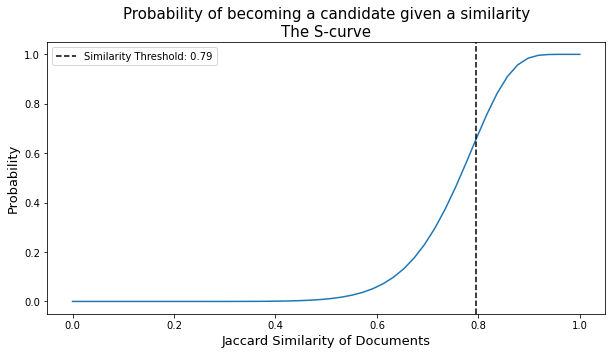

In [5]:
# plotting the s-curve
ax = lsh.plot_thresh()
plt.show()

In [6]:
from itertools import combinations
from scipy.spatial.distance import jaccard

def jaccard_sim(u, v):
    return 1 - jaccard(u, v)

similarities = [jaccard_sim(signature[u_idx], signature[v_idx]) \
                for u_idx, v_idx in combinations(range(1000), 2)]

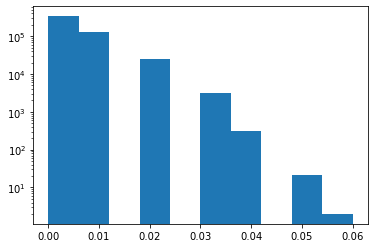

In [7]:
# jaccard similarity distribution
plt.hist(similarities, bins=10, log=True)
plt.show()

The above example illustrates a signature matrix with very low similarity scores as confirmed by the distribution plot of actual Jaccard similarities.

### Example 2 

Suppose we have a signature matrix where all items are similar. We see that across all bands, all the samples are placed in the same buckets. This time, we pass the `compute=True` flag to cast the `dask.bags` into a lists as values to the dictionary output of `get_buckets`.

In [8]:
# some edge case : all items are similar
n = 10
m = 100

# all values are 1
signature = np.full((n, m), 1)

lsh = LSH(signature)
lsh.make_bands(bands=10)
print("Rows per band: ", lsh.r)
print("Number of bands: ", lsh.bands)
display(lsh.get_buckets(compute=True))


Rows per band:  10
Number of bands:  10


{0: [(-4511045881551967787, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 1: [(-8359770896084742983, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 2: [(2866674764794135345, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 3: [(-4164649050109038293, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 4: [(-4511045881551967787, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 5: [(-8359770896084742983, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 6: [(2866674764794135345, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 7: [(-4164649050109038293, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 8: [(-4511045881551967787, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
 9: [(-8359770896084742983, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]}

### Example 3 
Suppose now another signature matrix where there are two groups of sets that are similar. We shall observe that for each band, we have two buckets corresponding to the two similarity groups (1's group and 2's group).

In [9]:
# two similar groups
n = 10 # total of 20 samples
m = 100

# concatentate two full matrices: matrix of 1's and 2's
signature = np.concatenate((np.full((n, m), 1), np.full((n, m), 2)))

lsh = LSH(signature)
lsh.make_bands(bands=10)
print("Rows per band: ", lsh.r)
print("Number of bands: ", lsh.bands)
display(lsh.get_buckets(compute=True))

Rows per band:  10
Number of bands:  10


{0: [(2866674764794135345, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (-8148071392985430698, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 1: [(-4164649050109038293, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (7929749226918372346, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 2: [(-4511045881551967787, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (499418812276172301, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 3: [(-8359770896084742983, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (5464707384305557384, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 4: [(2866674764794135345, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (-8148071392985430698, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 5: [(-4164649050109038293, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (7929749226918372346, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 6: [(-4511045881551967787, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (499418812276172301, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])],
 7: [(-8359770896084742983, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (5464707384305557384, [10, 11, 12, 1